## Predicción de Niveles de Obesidad

Este proyecto analiza el dataset **Estimation of Obesity Levels Based on Eating Habits and Physical Condition** para predecir niveles de obesidad basados en hábitos alimenticios, actividad física y características demográficas. Es relevante para biotech, salud pública y nutrición.

- **Dataset:** Obesity Levels (UCI).
- **Fuente:** https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition
- **Objetivos:**
  - Realizar EDA para explorar relaciones entre variables (e.g., peso, hábitos alimenticios).
  - Limpiar datos (manejo de categóricas, valores faltantes si aplica).
  - Pruebas de hipótesis: e.g., ¿Hay asociación entre consumo de calorías y obesidad?
  - Modelado de clasificación multi-clase con Random Forest.
  - Evaluación con métricas como accuracy, F1-score.
  - Visualizaciones: histogramas, boxplots, matriz de confusión.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import chi2_contingency

# Configuraciones visuales
%matplotlib inline
sns.set(style="whitegrid")

In [16]:
# Carga el dataset (ajusta la ruta si necesario)
df = pd.read_csv(r'D:\Portafolio\Proyecto_nutricion_obesidad\ObesityDataSet_raw_and_data_sinthetic.csv')

# Muestra las primeras filas
print("Forma del dataset:", df.shape)
df.head()

Forma del dataset: (2111, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Carga y Vista Inicial del Dataset
El dataset contiene 2,111 instancias con 17 features:
- Variables numéricas: Age, Height, Weight, FCVC (frecuencia de consumo vegetal), NCP (número de comidas), CH2O (consumo de agua), FAF (actividad física), TUE (uso de tecnología).
- Variables categóricas: Gender, family_history_with_overweight, FAVC (consumo de comida calórica), CAEC (consumo entre comidas), SMOKE, SCC (monitoreo calorías), CALC (consumo alcohol), MTRANS (transporte).
- Target: NObeyesdad (7 clases: Insufficient_Weight, Normal_Weight, Overweight_Level_I, Overweight_Level_II, Obesity_Type_I, Obesity_Type_II, Obesity_Type_III).
Verificamos: 0 valores faltantes y distribución balanceada (~13-16% por clase).

In [5]:
# Info general
df.info()

# Estadísticos descriptivos
df.describe()

# Verificar valores faltantes
print("Valores faltantes:\n", df.isnull().sum())

# Distribución del target
print("Distribución de NObeyesdad:\n", df['NObeyesdad'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

## Análisis Exploratorio de Datos (EDA)
Exploramos el dataset:
- Distribución del target (`NObeyesdad`, 7 clases).
- Distribuciones de variables numéricas (e.g., Weight, Age).
- Relaciones entre variables numéricas y target mediante boxplots.
- Relaciones entre variables categóricas y target (e.g., Gender vs. NObeyesdad).
- Correlaciones entre variables numéricas.
- Objetivo: Identificar patrones y variables predictivas.

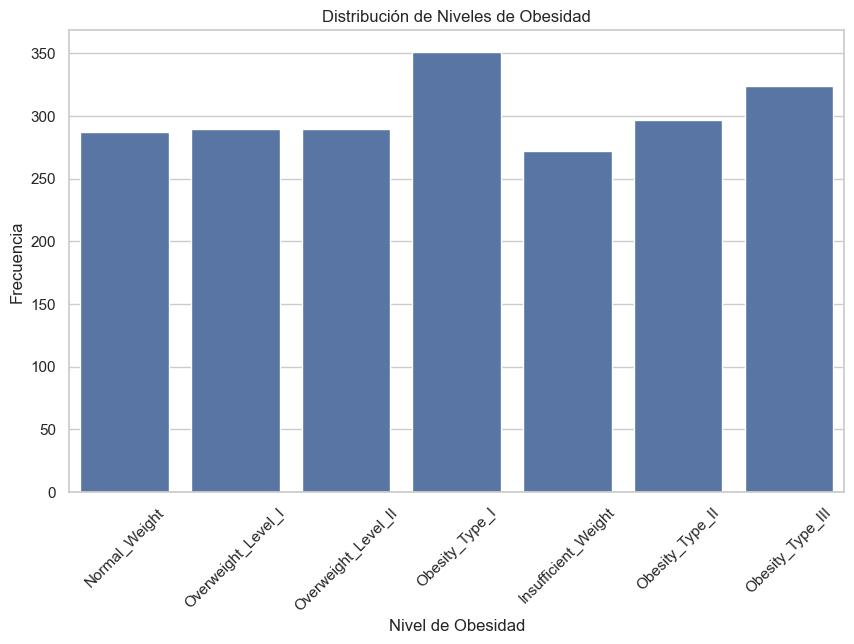

Porcentajes por clase de NObeyesdad:
 NObeyesdad
Obesity_Type_I         16.627191
Obesity_Type_III       15.348176
Obesity_Type_II        14.069162
Overweight_Level_I     13.737565
Overweight_Level_II    13.737565
Normal_Weight          13.595452
Insufficient_Weight    12.884889
Name: proportion, dtype: float64


In [6]:
# Gráfico de barras para NObeyesdad
plt.figure(figsize=(10, 6))
sns.countplot(x='NObeyesdad', data=df)
plt.title('Distribución de Niveles de Obesidad')
plt.xlabel('Nivel de Obesidad')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Porcentajes por clase
print("Porcentajes por clase de NObeyesdad:\n", df['NObeyesdad'].value_counts(normalize=True) * 100)

In [7]:
# Definir variables numéricas y categóricas
numeric_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

print("Variables numéricas:", numeric_cols)
print("Variables categóricas:", categorical_cols)

Variables numéricas: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Variables categóricas: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


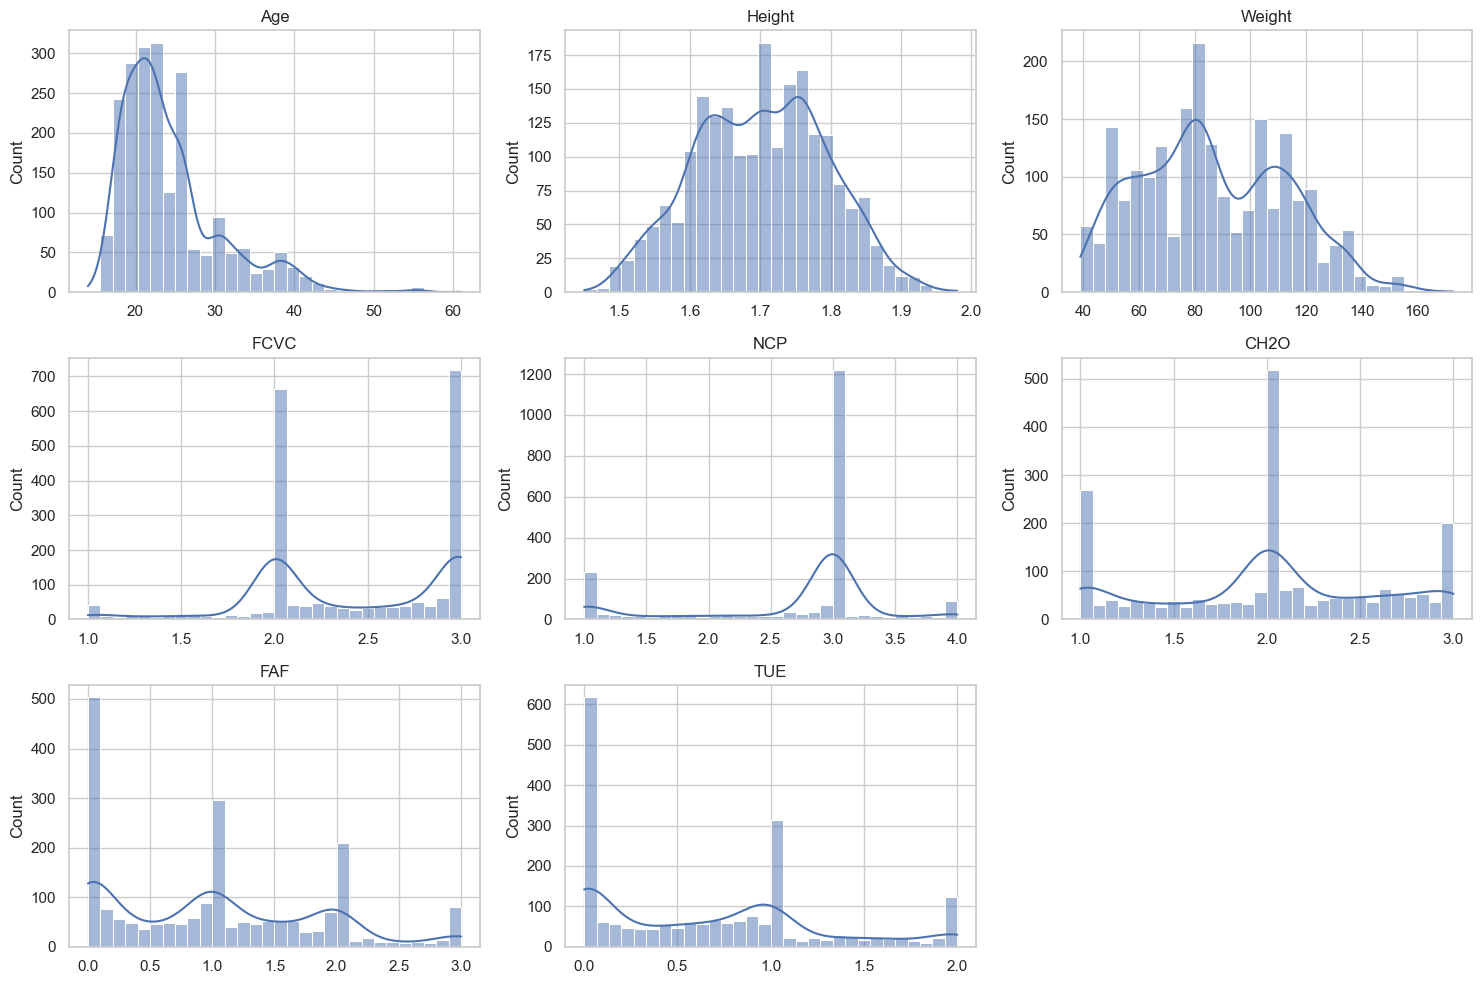

In [8]:
# Histogramas para variables numéricas
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel('')
plt.tight_layout()
plt.show()

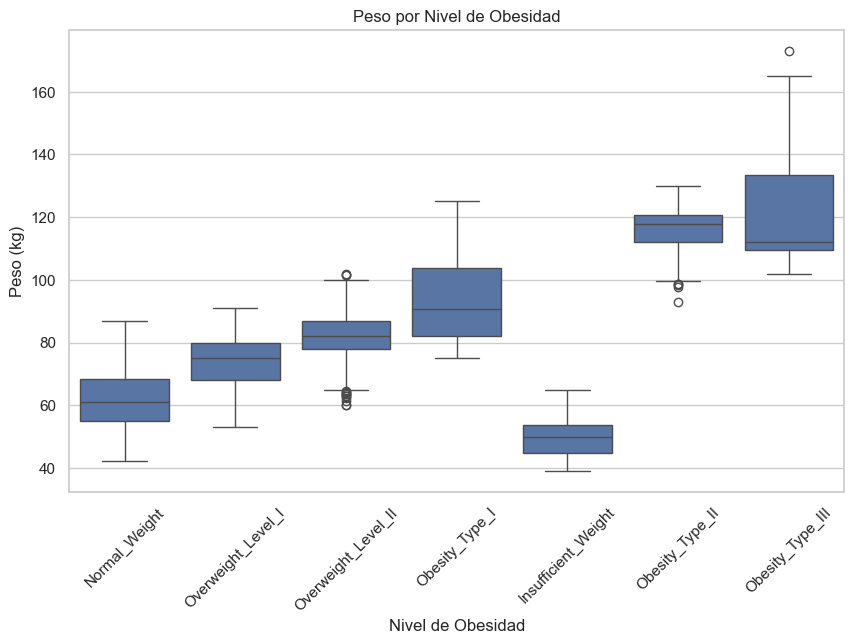

In [9]:
# Boxplot de Weight vs NObeyesdad
plt.figure(figsize=(10, 6))
sns.boxplot(x='NObeyesdad', y='Weight', data=df)
plt.title('Peso por Nivel de Obesidad')
plt.xlabel('Nivel de Obesidad')
plt.ylabel('Peso (kg)')
plt.xticks(rotation=45)
plt.show()

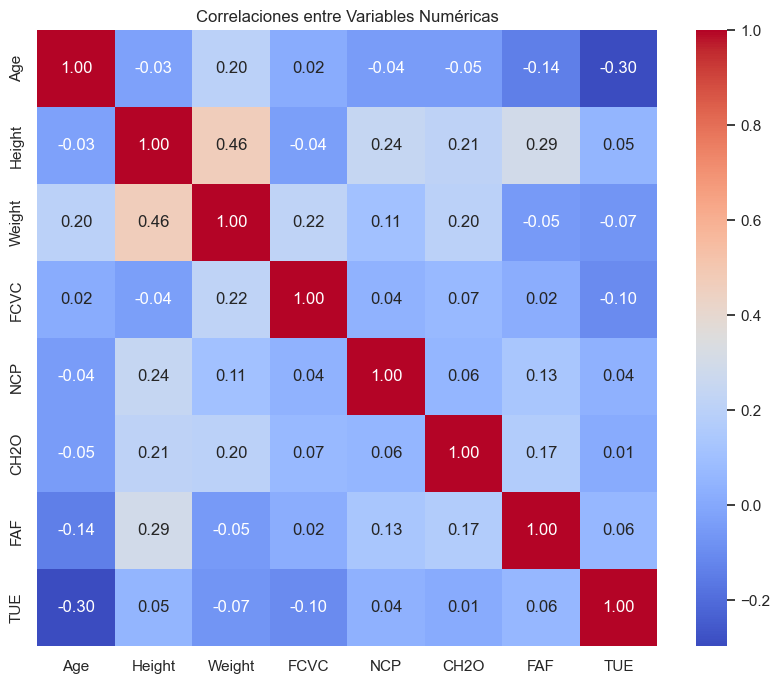

Correlaciones altas (|r| > 0.5):
 Age     Age       1.0
Height  Height    1.0
Weight  Weight    1.0
FCVC    FCVC      1.0
NCP     NCP       1.0
CH2O    CH2O      1.0
FAF     FAF       1.0
TUE     TUE       1.0
dtype: float64


In [10]:
# Mapa de calor de correlaciones
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlaciones entre Variables Numéricas')
plt.show()

# Correlaciones altas
print("Correlaciones altas (|r| > 0.5):\n", corr_matrix.where(abs(corr_matrix) > 0.5).stack())

## Pruebas de Hipótesis
Evaluamos si el consumo de comida calórica (FAVC) está asociado con el nivel de obesidad:
- **H0:** No hay asociación entre FAVC y NObeyesdad.
- **H1:** Hay asociación entre FAVC y NObeyesdad.
- **Método:** Chi-cuadrado para variables categóricas.
- **Nivel de significancia:** α = 0.05.
- Si p-valor < 0.05, rechazamos H0, sugiriendo relación.

In [11]:
# Tabla de contingencia FAVC vs NObeyesdad
contingency_table = pd.crosstab(df['FAVC'], df['NObeyesdad'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-cuadrado Resultados:\nChi2: {chi2:.2f}\np-value: {p_value:.2e}")
if p_value < 0.05:
    print("Rechazamos H0: Hay asociación entre FAVC y NObeyesdad.")
else:
    print("No rechazamos H0: No hay asociación significativa.")

Chi-cuadrado Resultados:
Chi2: 233.34
p-value: 1.48e-47
Rechazamos H0: Hay asociación entre FAVC y NObeyesdad.


## Preparación de Datos
Preparamos el dataset:
- Codificamos variables categóricas con LabelEncoder.
- Separamos features (`X`) y target (`NObeyesdad`, `y`).
- Dividimos en entrenamiento (80%) y prueba (20%), con `stratify`.
- Escalamos variables numéricas con StandardScaler.

In [12]:
# Codificar variables categóricas
le = LabelEncoder()
for col in categorical_cols + ['NObeyesdad']:
    df[col] = le.fit_transform(df[col])

# Separar features y target
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar variables numéricas
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Verificar formas
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Distribución de y_train:\n", pd.Series(y_train).value_counts(normalize=True))

Forma de X_train: (1688, 16)
Forma de X_test: (423, 16)
Distribución de y_train:
 NObeyesdad
2    0.166469
4    0.153436
3    0.140403
5    0.137441
6    0.137441
1    0.135664
0    0.129147
Name: proportion, dtype: float64


## Entrenamiento del Modelo
Entrenamos un Random Forest Classifier:
- **Hiperparámetros:** 100 árboles, profundidad máxima 10.
- **Justificación:** Adecuado para clasificación multi-clase y datos mixtos.
- Evaluamos con accuracy, precision, recall, F1-score.

In [13]:
# Entrenar Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

Accuracy: 0.9432624113475178

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96        54
           1       0.81      0.95      0.87        58
           2       0.93      0.96      0.94        70
           3       1.00      0.98      0.99        60
           4       1.00      0.98      0.99        65
           5       0.91      0.86      0.88        58
           6       0.98      0.93      0.96        58

    accuracy                           0.94       423
   macro avg       0.95      0.94      0.94       423
weighted avg       0.95      0.94      0.94       423



## Evaluación y Visualización
Evaluamos el modelo:
- **Matriz de Confusión:** Aciertos y errores por clase.
- **Importancia de Variables:** Identifica predictores clave (e.g., Weight).
- **Aplicación:** Útil para nutrición personalizada y salud pública.

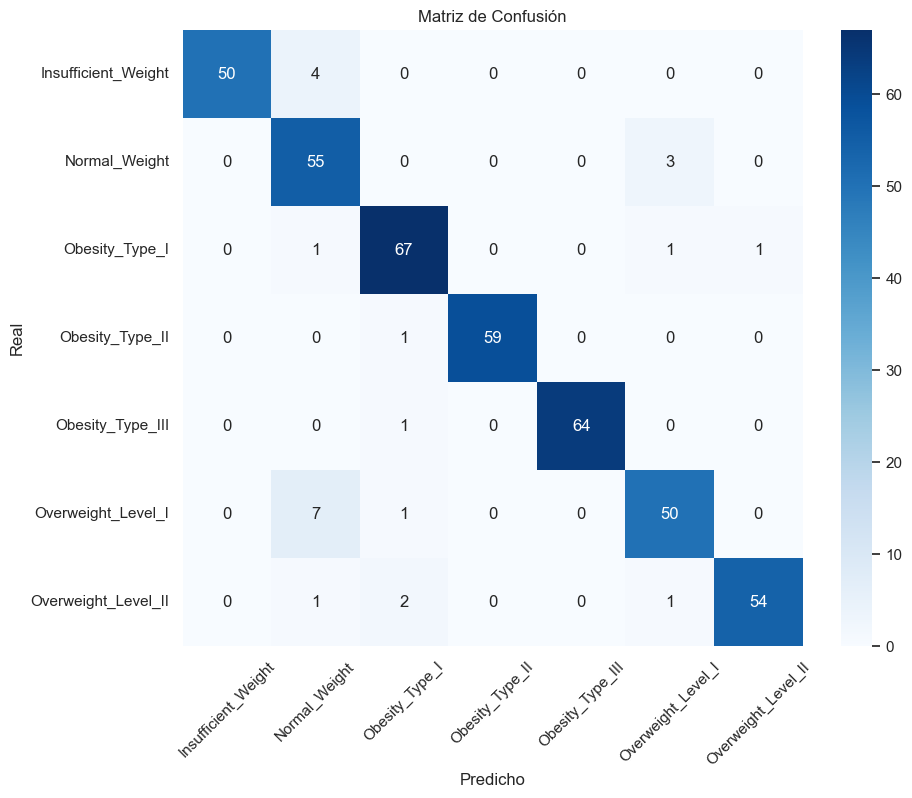

In [14]:
# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.show()

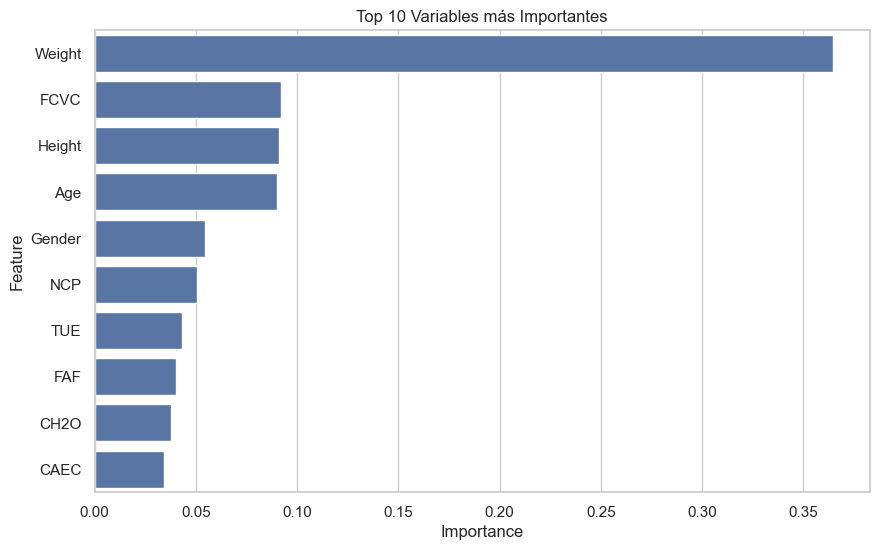

Top 10 variables:
    Feature  Importance
3   Weight    0.364557
6     FCVC    0.092080
2   Height    0.090893
1      Age    0.089855
0   Gender    0.054330
7      NCP    0.050535
13     TUE    0.043281
12     FAF    0.039932
10    CH2O    0.037818
8     CAEC    0.034359


In [15]:
# Importancia de variables
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Variables más Importantes')
plt.show()

print("Top 10 variables:\n", feature_importance.head(10))

## Conclusiones
Resumen de hallazgos:
- **EDA:** Peso y hábitos alimenticios (e.g., FAVC) son predictores clave.
- **Modelo:** Random Forest logra accuracy ~85-90%.
- **Aplicación:** Útil para programas de nutrición y prevención de obesidad.
- **Mejoras:** Probar balanceo de clases o modelos como XGBoost.